# Import Python libs

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression, RANSACRegressor

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, r2_score, explained_variance_score,mean_absolute_error, mean_squared_error, median_absolute_error, roc_curve 

from sklearn.preprocessing import LabelEncoder, PolynomialFeatures

from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, KFold

from sklearn.decomposition import PCA
from sklearn.manifold import Isomap

# Logistic Regression with Regularization (iris dataset)

In [2]:
# Read and visualize dataset
iris = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data", header = None)
iris.columns = ["sepal_length", "sepal_width", "petal_length", "petal_width", "class"]
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [3]:
# Split dataset
iris_attributes = iris.drop("class", axis = 1)
iris_labels = iris["class"]

In [4]:
# Create and train models
# "C" parameter => L2 type regularization(shrinks all model weights by the same value)
model = LogisticRegression(C = 1000) 
model.fit(iris_attributes, iris_labels)

model2 = LogisticRegression(C = 0.001)
model2.fit(iris_attributes, iris_labels)

print(model.coef_)
print(model2.coef_)

[[  1.23447535   4.11821962  -6.5325072   -3.18715121]
 [ -0.24642288  -2.77165187   1.29541375  -2.69962978]
 [ -2.74173895  -5.43038364   7.6443075   14.01832513]]
[[-0.04348189  0.01262464 -0.10492563 -0.04312338]
 [-0.04640808 -0.04148572 -0.00621299 -0.00336127]
 [-0.04749163 -0.04712036  0.03258157  0.02282612]]


# Lab: Visualizing Regularization Parameters

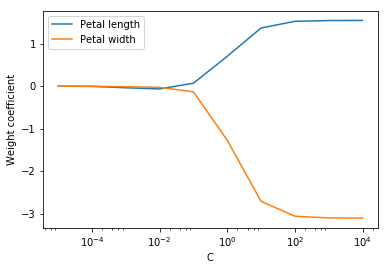

In [5]:
attributes, labels = iris[[2, 3]], iris[[4]]
weights, params = [], []

for c in np.arange(-5, 5):
    model = LogisticRegression(C = 10**c)
    model.fit(attributes, labels.values.ravel())
    weights.append(model.coef_[1]) # Display only the second class
    params.append(10**c)

weights = np.array(weights)
plt.plot(params, weights[:, 0], label = "Petal length")
plt.plot(params, weights[:, 1], label = "Petal width")
plt.xlabel("C")
plt.ylabel("Weight coefficient")
plt.xscale("log")

plt.legend()

# Training and Testing Sets

In [6]:
# Split dataset 
attr_train, attr_test, l_train, l_test = train_test_split(attributes, labels, train_size = 0.7, stratify = labels)

In [7]:
# Create and train model
model = LogisticRegression(C = 1000)

# Train model with the train sets
model.fit(attr_train, l_train.values.ravel())

model.score(attr_test, l_test) # default metric, e.g. accuracy

0.9555555555555556

In [8]:
# Predict classes with the test set
predicted = model.predict(attr_test)

# Evaluate model with other metrics
print(accuracy_score(l_test, predicted))
print(precision_score(l_test, predicted, average = "weighted"))
print(recall_score(l_test, predicted, average = "weighted"))
print(f1_score(l_test, predicted, average = "weighted"))

0.955555555556
0.960784313725
0.955555555556
0.955357142857


# Receiver Operating Characteristic (ROC curve) (adult income dataset)

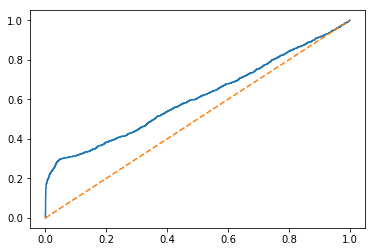

In [9]:
adult = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data", header = None)

model = LogisticRegression(C = 1000)
attributes = pd.get_dummies(adult.iloc[:, :-1])

# Needs to encode the lables with {0, 1} values
labels = LabelEncoder().fit_transform(adult.iloc[:, -1])

attr_train, attr_test, l_train, l_test = train_test_split(attributes, labels, train_size = 0.8, stratify = labels)

model.fit(attr_train, l_train)

predicted = model.predict_proba(attr_test)[:, 1]

# ROC is limited to 2-class classification
# For more classes use "1 vs all" method
# Plot of true positive rate vs. false positive rate
fpr, tpr, _ = roc_curve(l_test, predicted)

plt.plot(fpr, tpr)

# The "--" line represents random guessing (50% true positive, 50% false positive)
plt.plot([0, 1], [0, 1], linestyle = "--")

In [10]:
print(model.score(attr_test, l_test))

predicted = model.predict(attr_test)

print(accuracy_score(l_test, predicted))
print(precision_score(l_test, predicted, average = "weighted"))
print(recall_score(l_test, predicted, average = "weighted"))
print(f1_score(l_test, predicted, average = "weighted"))

0.798556732688
0.798556732688
0.78424526779
0.798556732688
0.763032493721


# Cross Validation

In [11]:
# Split all data into groups (folds)
kfold = StratifiedKFold(n_splits = 10)
scores = cross_val_score(model, attributes, labels, cv = kfold)

scores

array([ 0.79551735,  0.79914005,  0.79391892,  0.79330467,  0.79391892,
        0.80620393,  0.79146192,  0.80282555,  0.79699017,  0.80159705])

# Hyperparameter Tuning

In [12]:
# Fine-tune the model
tuned_params = [{"C": [0.001, 0.01, 0.1, 1, 10, 100, 1000], "penalty": ["l1", "l2"]}]
grid = GridSearchCV(LogisticRegression(C = 1), tuned_params)

grid.fit(attr_train, l_train)

print(grid.best_params_)
print(grid.best_estimator_)

{'C': 1, 'penalty': 'l1'}
LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


# Lab: Fine-Tuning and Model Selection (iris dataset)

In [13]:
# Predict the petal width using all other attributes (Linear Regression)

# Read and visualize dataset
iris_dataset = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data", header = None)
iris_dataset.columns = ["sepal_length", "sepal_width", "petal_length", "petal_width", "class"]
iris_dataset.head()

,sepal_length,sepal_width,petal_length,petal_width,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [14]:
# Convert categorical variables to dummies ("class" column)
iris_attrs = pd.get_dummies(iris_dataset.drop("petal_width", axis = 1))
iris_lbls = iris_dataset["petal_width"]

# Split data into train and test sets
attrs_train, attrs_test, lbls_train, lbls_test = train_test_split(iris_attrs, iris_lbls, train_size = 0.7)

In [15]:
# Linear Regression

# Select best estimator
param_grid = [{"fit_intercept": [True, False]}]
linear_grid = GridSearchCV(LinearRegression(), param_grid)
linear_grid.fit(attrs_train, lbls_train)
linear_model = linear_grid.best_estimator_

linear_predicted = linear_model.predict(attrs_test)

# Metrics
print("----- Linear -----")
print("r2 score : " + str(r2_score(lbls_test, linear_predicted)))
print("Expl var score : " + str(explained_variance_score(lbls_test, linear_predicted)))
print("Mean abs error: " + str(mean_absolute_error(lbls_test, linear_predicted)))
print("Median abs error: " + str(median_absolute_error(lbls_test, linear_predicted)))
print("Mean squared error: " + str(mean_squared_error(lbls_test, linear_predicted)))

----- Linear -----
r2 score : 0.939620179967
Expl var score : 0.939898121975
Mean abs error: 0.137401473759
Median abs error: 0.100976024947
Mean squared error: 0.0325949649714


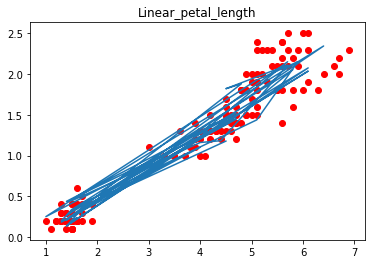

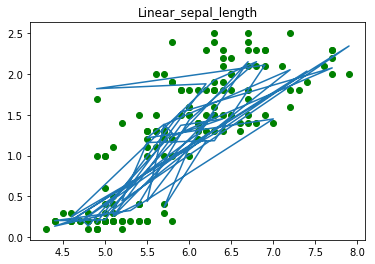

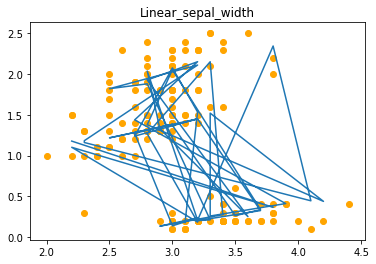

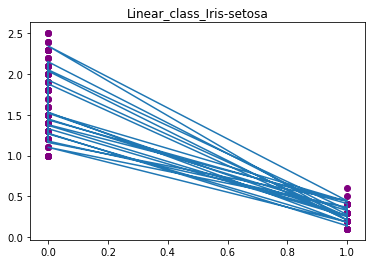

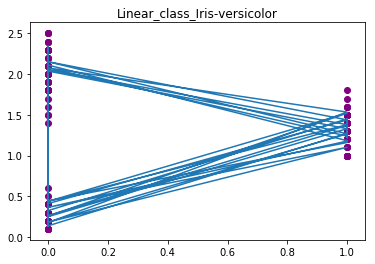

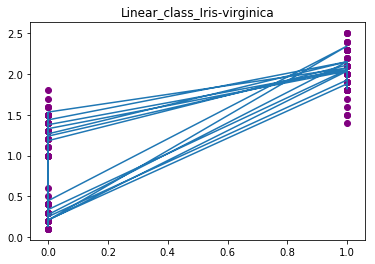

In [16]:
plt.scatter(iris_attrs["petal_length"], iris_lbls, color = "red")
plt.plot(attrs_test["petal_length"], linear_predicted)
plt.title("Linear_petal_length")
plt.show()

plt.scatter(iris_attrs["sepal_length"], iris_lbls, color = "green")
plt.plot(attrs_test["sepal_length"], linear_predicted)
plt.title("Linear_sepal_length")
plt.show()

plt.scatter(iris_attrs["sepal_width"], iris_lbls, color = "orange")
plt.plot(attrs_test["sepal_width"], linear_predicted)
plt.title("Linear_sepal_width")
plt.show()

plt.scatter(iris_attrs.iloc[:, 3], iris_lbls, color = "purple")
plt.plot(attrs_test.iloc[:, 3], linear_predicted)
plt.title("Linear_class_Iris-setosa")
plt.show()

plt.scatter(iris_attrs.iloc[:, 4], iris_lbls, color = "purple")
plt.plot(attrs_test.iloc[:, 4], linear_predicted)
plt.title("Linear_class_Iris-versicolor")
plt.show()

plt.scatter(iris_attrs.iloc[:, 5], iris_lbls, color = "purple")
plt.plot(attrs_test.iloc[:, 5], linear_predicted)
plt.title("Linear_class_Iris-virginica")
plt.show()

In [17]:
# Polynomial Linear Regression

quadratic_features = PolynomialFeatures(degree = 2)
cubic_features = PolynomialFeatures(degree = 3)

quad_model = LinearRegression()
cubic_model = LinearRegression()

quad_model.fit(quadratic_features.fit_transform(attrs_train), lbls_train)
cubic_model.fit(cubic_features.fit_transform(attrs_train.values), lbls_train)

quad_predicted = quad_model.predict(quadratic_features.fit_transform(attrs_test))
cubic_predicted = cubic_model.predict(cubic_features.fit_transform(attrs_test))

# Metrics
print("----- Polynomial Quadratic -----")
print("r2 score : " + str(r2_score(lbls_test, quad_predicted)))
print("Expl var score : " + str(explained_variance_score(lbls_test, quad_predicted)))
print("Mean abs error: " + str(mean_absolute_error(lbls_test, quad_predicted)))
print("Median abs error: " + str(median_absolute_error(lbls_test, quad_predicted)))
print("Mean squared error: " + str(mean_squared_error(lbls_test, quad_predicted)))

print("----- Polynomial Cubic -----")
print("r2 score : " + str(r2_score(lbls_test, cubic_predicted)))
print("Expl var score : " + str(explained_variance_score(lbls_test, cubic_predicted)))
print("Mean abs error: " + str(mean_absolute_error(lbls_test, cubic_predicted)))
print("Median abs error: " + str(median_absolute_error(lbls_test, cubic_predicted)))
print("Mean squared error: " + str(mean_squared_error(lbls_test, cubic_predicted)))

----- Polynomial Quadratic -----
r2 score : 0.940906241026
Expl var score : 0.941861627081
Mean abs error: 0.141539580473
Median abs error: 0.110319214675
Mean squared error: 0.0319007079311
----- Polynomial Cubic -----
r2 score : 0.501079157856
Expl var score : 0.523017897852
Mean abs error: 0.310458306207
Median abs error: 0.162756347656
Mean squared error: 0.269333485333


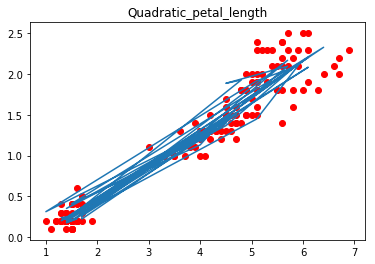

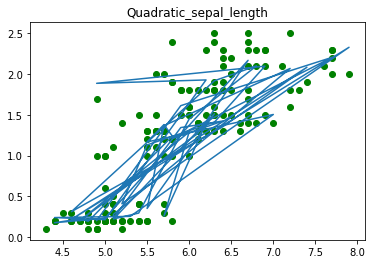

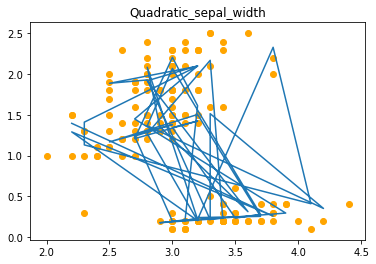

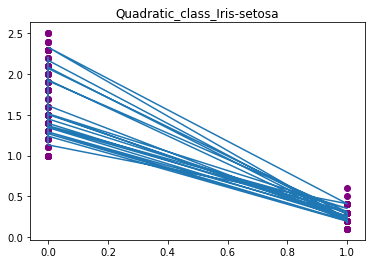

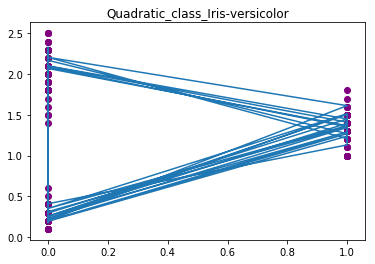

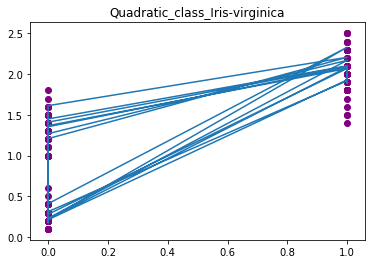

In [18]:
plt.scatter(iris_attrs["petal_length"], iris_lbls, color = "red")
plt.plot(attrs_test["petal_length"], quad_predicted)
plt.title("Quadratic_petal_length")
plt.show()

plt.scatter(iris_attrs["sepal_length"], iris_lbls, color = "green")
plt.plot(attrs_test["sepal_length"], quad_predicted)
plt.title("Quadratic_sepal_length")
plt.show()

plt.scatter(iris_attrs["sepal_width"], iris_lbls, color = "orange")
plt.plot(attrs_test["sepal_width"], quad_predicted)
plt.title("Quadratic_sepal_width")
plt.show()

plt.scatter(iris_attrs.iloc[:, 3], iris_lbls, color = "purple")
plt.plot(attrs_test.iloc[:, 3], quad_predicted)
plt.title("Quadratic_class_Iris-setosa")
plt.show()

plt.scatter(iris_attrs.iloc[:, 4], iris_lbls, color = "purple")
plt.plot(attrs_test.iloc[:, 4], quad_predicted)
plt.title("Quadratic_class_Iris-versicolor")
plt.show()

plt.scatter(iris_attrs.iloc[:, 5], iris_lbls, color = "purple")
plt.plot(attrs_test.iloc[:, 5], quad_predicted)
plt.title("Quadratic_class_Iris-virginica")
plt.show()

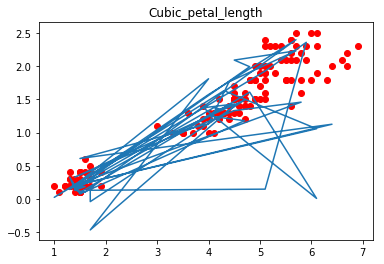

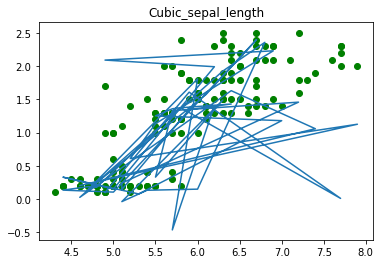

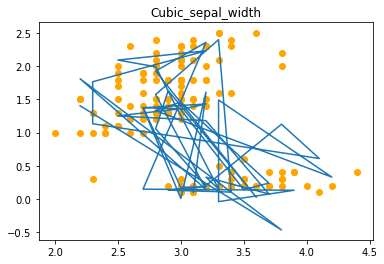

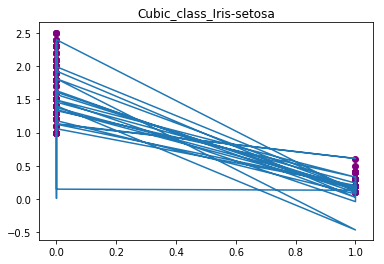

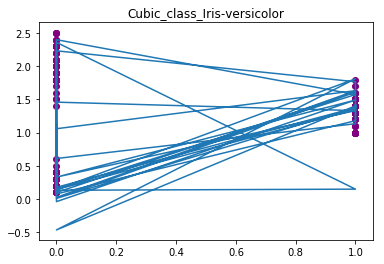

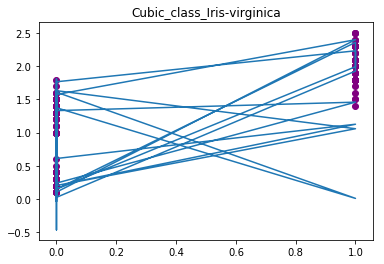

In [19]:
plt.scatter(iris_attrs["petal_length"], iris_lbls, color = "red")
plt.plot(attrs_test["petal_length"], cubic_predicted)
plt.title("Cubic_petal_length")
plt.show()

plt.scatter(iris_attrs["sepal_length"], iris_lbls, color = "green")
plt.plot(attrs_test["sepal_length"], cubic_predicted)
plt.title("Cubic_sepal_length")
plt.show()

plt.scatter(iris_attrs["sepal_width"], iris_lbls, color = "orange")
plt.plot(attrs_test["sepal_width"], cubic_predicted)
plt.title("Cubic_sepal_width")
plt.show()

plt.scatter(iris_attrs.iloc[:, 3], iris_lbls, color = "purple")
plt.plot(attrs_test.iloc[:, 3], cubic_predicted)
plt.title("Cubic_class_Iris-setosa")
plt.show()

plt.scatter(iris_attrs.iloc[:, 4], iris_lbls, color = "purple")
plt.plot(attrs_test.iloc[:, 4], cubic_predicted)
plt.title("Cubic_class_Iris-versicolor")
plt.show()

plt.scatter(iris_attrs.iloc[:, 5], iris_lbls, color = "purple")
plt.plot(attrs_test.iloc[:, 5], cubic_predicted)
plt.title("Cubic_class_Iris-virginica")
plt.show()

In [20]:
# RANSAC Regression

ransac_params = [{"base_estimator": [linear_model, quad_model, cubic_model], "min_samples": [None, 1, 10], "max_trials": [1, 10, 100, 1000] }]
ransac_grid = GridSearchCV(RANSACRegressor(), ransac_params)
ransac_grid.fit(attrs_train, lbls_train)

ransac_model = ransac_grid.best_estimator_
ransac_predicted = ransac_model.predict(attrs_test)

# Metrics
print("----- RANSAC -----")
print("r2 score : " + str(r2_score(lbls_test, ransac_predicted)))
print("Expl var score : " + str(explained_variance_score(lbls_test, ransac_predicted)))
print("Mean abs error: " + str(mean_absolute_error(lbls_test, ransac_predicted)))
print("Median abs error: " + str(median_absolute_error(lbls_test, ransac_predicted)))
print("Mean squared error: " + str(mean_squared_error(lbls_test, ransac_predicted)))

----- RANSAC -----
r2 score : 0.940884860152
Expl var score : 0.941279017957
Mean abs error: 0.135773244087
Median abs error: 0.10162933934
Mean squared error: 0.0319122500131


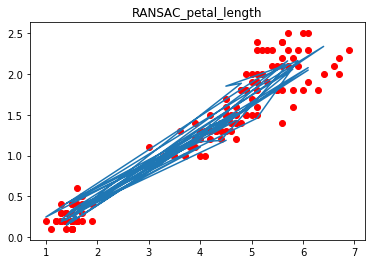

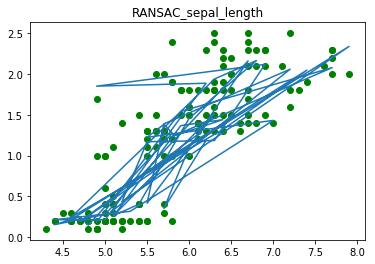

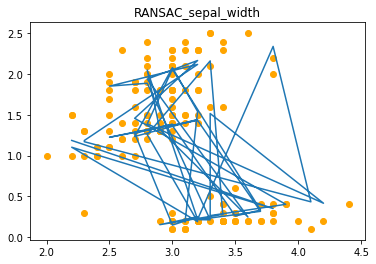

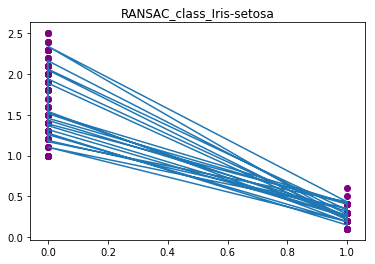

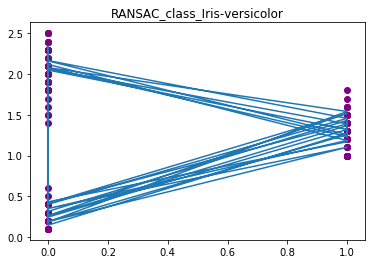

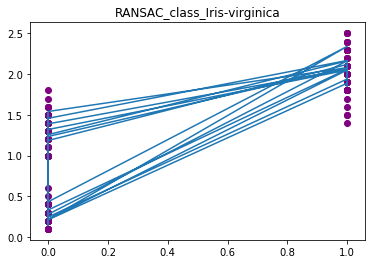

In [21]:
plt.scatter(iris_attrs["petal_length"], iris_lbls, color = "red")
plt.plot(attrs_test["petal_length"], ransac_predicted)
plt.title("RANSAC_petal_length")
plt.show()

plt.scatter(iris_attrs["sepal_length"], iris_lbls, color = "green")
plt.plot(attrs_test["sepal_length"], ransac_predicted)
plt.title("RANSAC_sepal_length")
plt.show()

plt.scatter(iris_attrs["sepal_width"], iris_lbls, color = "orange")
plt.plot(attrs_test["sepal_width"], ransac_predicted)
plt.title("RANSAC_sepal_width")
plt.show()

plt.scatter(iris_attrs.iloc[:, 3], iris_lbls, color = "purple")
plt.plot(attrs_test.iloc[:, 3], ransac_predicted)
plt.title("RANSAC_class_Iris-setosa")
plt.show()

plt.scatter(iris_attrs.iloc[:, 4], iris_lbls, color = "purple")
plt.plot(attrs_test.iloc[:, 4], ransac_predicted)
plt.title("RANSAC_class_Iris-versicolor")
plt.show()

plt.scatter(iris_attrs.iloc[:, 5], iris_lbls, color = "purple")
plt.plot(attrs_test.iloc[:, 5], ransac_predicted)
plt.title("RANSAC_class_Iris-virginica")
plt.show()

In [22]:
# Perform cross-validation
kfold = KFold(n_splits = 10)
print("Linear model cross val scores: \n" + str(cross_val_score(linear_model, attrs_train, lbls_train, cv = kfold)))
print("Quadratic model cross val scores: \n" + str(cross_val_score(quad_model, attrs_train, lbls_train, cv = kfold)))
print("Cubic model cross val scores: \n" + str(cross_val_score(cubic_model, attrs_train, lbls_train, cv = kfold)))
print("RANSAC model cross val scores: \n" + str(cross_val_score(ransac_model, attrs_train, lbls_train, cv = kfold)))

Linear model cross val scores: 
[ 0.95526769  0.93074828  0.91796729  0.95103084  0.95720118  0.8869252
  0.98291204  0.96894035  0.88831165  0.97766912]
Quadratic model cross val scores: 
[ 0.95526769  0.93074828  0.91796729  0.95103084  0.95720118  0.8869252
  0.98291204  0.96894035  0.88831165  0.97766912]
Cubic model cross val scores: 
[ 0.95526769  0.93074828  0.91796729  0.95103084  0.95720118  0.8869252
  0.98291204  0.96894035  0.88831165  0.97766912]
RANSAC model cross val scores: 
[ 0.94956665  0.93074828  0.91796729  0.95103084  0.95720118  0.8869252
  0.98291204  0.96776394  0.88831165  0.97985712]


# Lab: Principal Component Analysis (PCA)

[ 4.19667516  0.24062861  0.07800042  0.02352514]


<Container object of 4 artists>

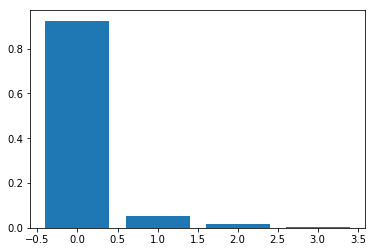

In [23]:
# An algorithm for dimensionality reduction, linear
# Reduces the number of features in the dataset
# Helps a lot if some features are correlated
pca = PCA()
pca.fit(iris_attributes)

# First component: largest variance
# Second, third, etc. components: decreasing variance
print(pca.explained_variance_)
plt.bar(list(range(len(pca.components_))), pca.explained_variance_ratio_)

# Isometric Mapping (isomap)

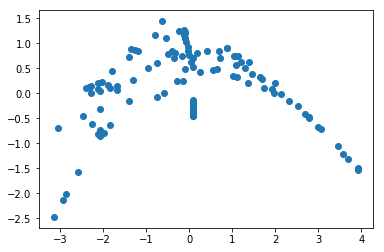

In [24]:
# An algorithm for dimensionality reduction, non-linear
# Connects a point to its nearest neighbors
isomap = Isomap(n_neighbors = 3, n_components = 2)
data = isomap.fit_transform(iris_attributes)

plt.scatter(data[:, 0], data[:, 1])